Step 4:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import altair as alt

In [2]:
df = pd.read_csv("imputed_data_final.csv")
df = df[df.columns[4:]]
df.head(5)

,Year,EVI,Height,HSUS,Immigration,Life Expectancy,Polarization,Wage GDP Ratio,fatalities,riot_economic,...,ne_count,ok_count,hi_count,sd_count,nd_count,ia_count,ak_count,NA_count,Population,Political Instability
0,1782,25.27862,173.108454,19.258893,1.496999,55.768842,0.371811,1.090890,1.0,0,...,0,0,0,0,0,0,0,0,2.970621e+06,-1.088771
1,1784,25.27862,173.063703,19.004489,1.496999,56.035361,0.371811,1.090890,9.0,4,...,0,0,0,0,0,0,0,0,3.188095e+06,1.143161
2,1787,25.27862,172.974200,19.098354,1.496999,56.071185,0.371811,1.090890,20.0,0,...,0,0,0,0,0,0,0,0,3.553406e+06,2.099389
3,1788,25.27862,172.929448,18.675441,1.496999,56.126853,0.371811,1.091615,3.0,0,...,0,0,0,0,0,0,0,0,3.677840e+06,2.163410
4,1791,26.45349,172.892156,18.544447,1.566766,56.063206,0.532692,1.146261,1.0,1,...,0,0,0,0,0,0,0,0,4.056153e+06,1.777819


In [3]:
state_list = ['NC', 'PA', 'TN', 'TX', 'AL', 'AR', 'GA', 'IL', 'KY', 'LA', 'MS', 'SC']
state_list = [val.lower() for val in state_list]
state_list = [state + "_count" for state in state_list]
type_subtype = ["riot_labor","riot_political","riot_race","lynching_extralegal","lynching_political","lynching_race","rampage_education","rampage_political","rampage_race"]

In [4]:
df["weighted_states"] = df[state_list].sum(axis = 1)

In [5]:
df["Num_Locations"] = df[df.columns[91:143]].astype(bool).sum(axis=1)

In [6]:
df["type_subtype_sum"] = df[type_subtype].sum(axis = 1)

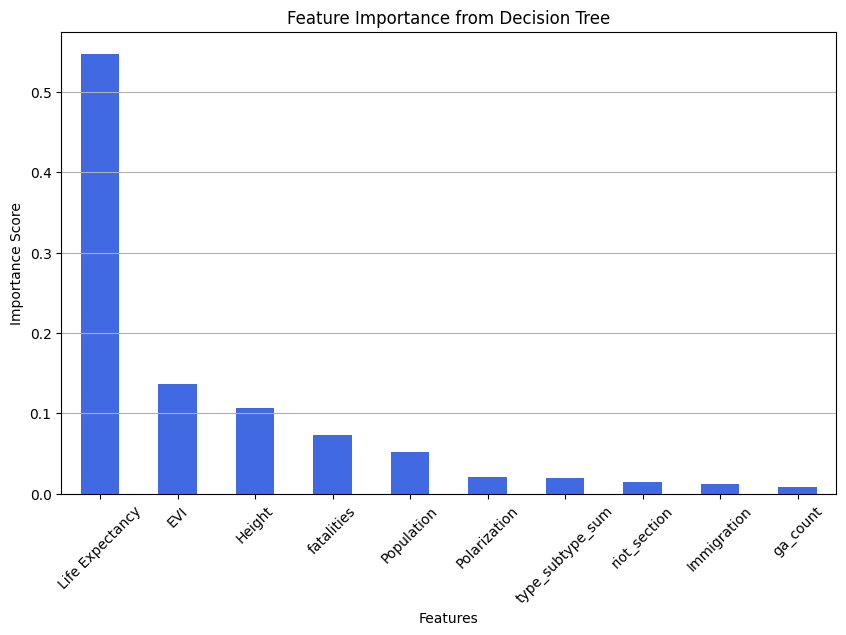

Top 3 Features: ['Life Expectancy', 'EVI', 'Height']


In [7]:
df = df.select_dtypes(include=[np.number]).dropna()
X = df.drop(columns=["Political Instability"])
y = df["Political Instability"]


dtree = DecisionTreeRegressor(
    max_depth=5,  # Limit depth to avoid overfitting
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dtree.fit(X.drop(["Year"],axis = 1), y)

feature_importance1 = pd.Series(dtree.feature_importances_, index=X.drop(["Year"],axis = 1).columns).sort_values(ascending=False)
top_features = feature_importance1.head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='bar', color='royalblue')
plt.title("Feature Importance from Decision Tree")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# Select the top 5 features
top_3_features = top_features.head(3).index.tolist()
print("Top 3 Features:", top_3_features)



In [8]:
df_feature1 = feature_importance1.reset_index()
index_val = list(df_feature1[:40]["index"])

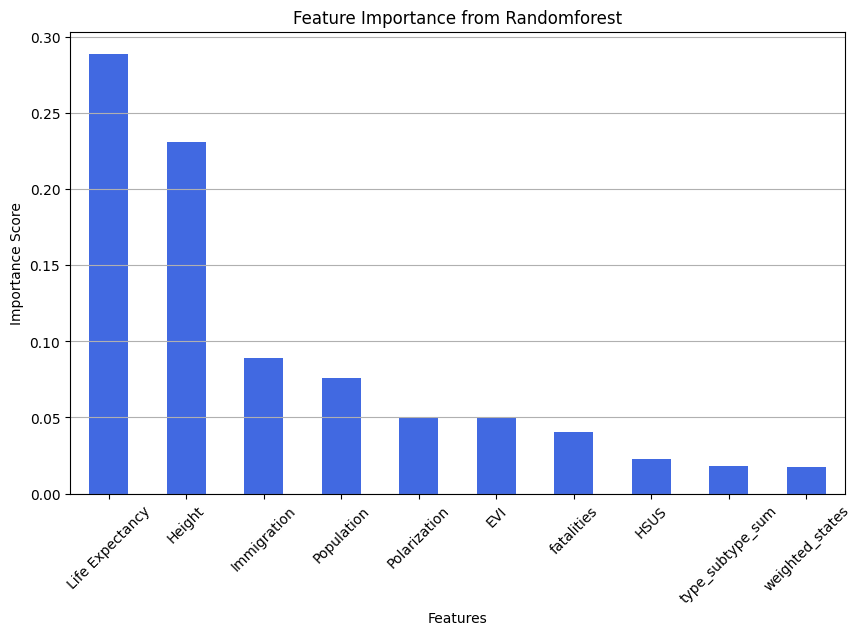

In [9]:
from sklearn.ensemble import RandomForestRegressor as rnd_frst
from sklearn.model_selection import cross_val_score, \
                                    LeaveOneOut, RepeatedKFold
from sklearn.metrics import mean_squared_error, roc_curve, auc, \
                            f1_score    

model = rnd_frst(max_depth=5, n_estimators=100, random_state = 42)
#k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
#scores = cross_val_score(model, X_train, y_train, 
                    # scoring='neg_mean_squared_error',
                    # cv=k_folds, n_jobs=None) 
                           



model.fit(X.drop(["Year"],axis=1), y)

feature_importance2 = pd.Series(model.feature_importances_, index=X.drop(["Year"],axis = 1).columns).sort_values(ascending=False)
top_features = feature_importance2.head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='bar', color='royalblue')
plt.title("Feature Importance from Randomforest")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

In [10]:
df_feature2 = feature_importance2.reset_index()
index_val2 = list(df_feature2[:40]["index"])

In [11]:
features = list(set(index_val).intersection(set(index_val2)))

In [12]:
from sklearn.decomposition import PCA

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

In [14]:
df2 = pd.DataFrame(scaled_features)

In [15]:
for i in range(len(df2.columns)):
    df2 = df2.rename({i:features[i]},axis = 1)

In [16]:
df2["Political Instability"] = df["Political Instability"]

In [17]:
df2

,Polarization,pa_count,Immigration,Life Expectancy,riot_section,Height,EVI,nc_count,ky_count,HSUS,...,ga_count,Population,il_count,mo_count,fatalities,type_subtype_sum,Wage GDP Ratio,ms_count,la_count,Political Instability
0,-1.642954,-0.508810,-2.022672,0.475214,-0.207453,-0.229265,-0.941860,-0.306855,-0.369244,-1.442408,...,-0.331021,-1.205319,-0.473481,-0.373337,-0.346788,-0.652637,1.345003,-0.426375,-0.365791,-1.088771
1,-1.642954,2.608659,-2.022672,0.538631,-0.207453,-0.244490,-0.941860,-0.306855,-0.369244,-1.477072,...,-0.331021,-1.202907,-0.473481,-0.373337,-0.306140,-0.526678,1.345003,-0.426375,-0.365791,1.143161
2,-1.642954,-0.508810,-2.022672,0.547155,-0.207453,-0.274940,-0.941860,-0.306855,-0.369244,-1.464283,...,-0.331021,-1.198855,-0.473481,-0.373337,-0.250248,-0.274760,1.345003,-0.426375,-0.365791,2.099389
3,-1.642954,-0.508810,-2.022672,0.560401,-0.207453,-0.290165,-0.941860,-0.306855,-0.369244,-1.521907,...,-0.331021,-1.197474,-0.473481,-0.373337,-0.336626,-0.652637,1.348500,-0.426375,-0.365791,2.163410
4,-0.644674,-0.508810,-2.005298,0.545257,-0.207453,-0.302853,-0.939850,-0.306855,-0.369244,-1.539756,...,-0.331021,-1.193278,-0.473481,-0.373337,-0.346788,-0.778596,1.611980,-0.426375,-0.365791,1.777819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,1.949369,-0.508810,0.557924,1.079789,-0.207453,0.987801,0.708684,-0.306855,-0.369244,1.023952,...,-0.331021,2.076413,-0.473481,1.264256,-0.235005,-0.778596,-1.696343,-0.426375,-0.365791,-0.840085
189,1.999512,-0.508810,0.557924,1.079789,-0.207453,0.987801,0.731203,-0.306855,-0.369244,1.023952,...,-0.331021,2.105305,-0.473481,-0.373337,-0.209600,-0.526678,-1.723780,-0.426375,0.436456,-1.017228
190,2.048350,0.270557,0.557924,1.079789,-0.207453,0.987801,0.755938,-0.306855,-0.369244,1.023952,...,-0.331021,2.133254,0.498666,2.901850,-0.036845,-0.400719,-1.707418,-0.426375,0.436456,-0.617034
191,2.095826,2.608659,0.557924,1.079789,-0.207453,0.987801,0.785012,0.953211,1.929597,1.023952,...,0.219729,2.160259,0.498666,-0.373337,0.374530,1.236747,-1.736365,-0.426375,-0.365791,-0.041424


In [18]:
#Takes the most importance features in decision tree and random forest and then pca
model = PCA(n_components=3)
X = model.fit_transform(df2.drop(["Political Instability"],axis = 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [19]:
#Use just three columns from the original dataframe
X_new = df[["Life Expectancy","EVI","Height"]]
X_new = scaler.fit_transform(X_new)
y = df["Political Instability"]
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=12)

In [20]:
#Do pca on full dataset
model = PCA(n_components=3)
X_pca = model.fit_transform(df.drop(["Year","Political Instability"],axis = 1))
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=12)

In [21]:
models = [RandomForestRegressor(n_estimators=100, random_state=42), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),LassoCV(alphas=np.logspace(-3, 3, 10), cv=5,max_iter=10000)]

In [22]:
for model_val in models:
    model_val.fit(X_train, y_train)
    y_pred = model_val.predict(X_test)

    mse_rf = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred) 
    print(mse_rf,r2, mae)

0.2754753706349002 0.8640106938523852 0.371002219912968
0.26440997878398276 0.869473160266677 0.37729061618720866
1.3776891801059015 0.31989928806382284 0.8378727185205002


In [23]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

In [24]:
features = df.drop(["Year","Political Instability"],axis = 1).columns
scaled_data = pd.DataFrame(scaler.fit_transform(df[features]))
pca_model = PCA(n_components = 3)
pca_data = pd.DataFrame(pca_model.fit_transform(scaled_data))

In [25]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [26]:
def compare_dimensionality_reduction_gaussian(model_data):
    #model_data = pd.DataFrame(model.fit_transform(scaled_data))
    
    sse = []
    for k in np.arange(2,11):
        gmm = GaussianMixture (n_components=k, random_state = 42)
        gmm.fit(model_data)
        sse.append(gmm.bic(model_data))
    

    plt.plot(np.arange(2,11), sse, color = "green")
    plt.xlabel('Number of Clusters')
    plt.ylabel('BIC Score')  
    plt.show()


    silhouette = []
    for k in np.arange(2,11):
        gmm = GaussianMixture(n_components=k, random_state = 42)
        labels = gmm.fit_predict(model_data)
        score = silhouette_score(model_data, labels)
        silhouette.append(score)
    
    plt.plot(np.arange(2,11), silhouette, color = "purple")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')  
    plt.show()
    
    davies_bouldin = []
    for k in np.arange(2,11):
        gmm = GaussianMixture(n_components=k, random_state = 42)
        labels = gmm.fit_predict(model_data)
        score = davies_bouldin_score(model_data, labels)
        davies_bouldin.append(score)
    
    plt.plot(np.arange(2,11), davies_bouldin, color = "orange")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies Bouldin Score') 
    plt.show()
    

In [27]:
def compare_dimensionality_reduction_kmeans(model_data):
    #model_data = pd.DataFrame(model.fit_transform(scaled_data))
    kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300, 'random_state':100}
    sse = []
    for k in np.arange(2,11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(model_data)
        sse.append(kmeans.inertia_)
    
    kl = KneeLocator(np.arange(2,11), sse, curve='convex', direction='decreasing')
    #print('Automatically found elbow at %d clusters.'%kl.elbow)

    plt.plot(np.arange(2,11), sse, color = "green")
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')  
    plt.scatter(kl.elbow, kl.elbow_y, s=150, c='#a8323e')
    plt.show()


    silhouette = []
    for k in np.arange(2,11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(model_data)
        score = silhouette_score(model_data, kmeans.labels_)
        silhouette.append(score)
    
    plt.plot(np.arange(2,11), silhouette, color = "purple")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')  
    plt.show()
    
    davies_bouldin = []
    for k in np.arange(2,11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(model_data)
        score = davies_bouldin_score(model_data, kmeans.labels_)
        davies_bouldin.append(score)
    
    plt.plot(np.arange(2,11), davies_bouldin, color = "orange")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies Bouldin Score') 
    plt.show()
    

In [28]:
def compare_dimensionality_reduction_linkage(model_data):
    #model_data = pd.DataFrame(model.fit_transform(scaled_data))

    hierarchical = linkage(model_data, method='ward')
    sse = []
    for k in np.arange(2,11):
        hc_labels = fcluster(hierarchical, k, criterion='maxclust')
        model_data["labels"] = hc_labels
        centroids = np.array([model_data[model_data["labels"] == cluster].drop("labels",axis = 1).mean(axis=0) for cluster in np.unique(hc_labels)])
        sse.append(np.sum(np.min(cdist(model_data.drop("labels",axis = 1), centroids, 'euclidean'), axis=1) ** 2))

    plt.plot(np.arange(2,11), sse, color = "green")
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')  
    plt.show()

    model_data = model_data.drop("labels",axis = 1)
    silhouette = []
    for k in np.arange(2,11):
        hc_labels = fcluster(hierarchical, k, criterion='maxclust')
        score = silhouette_score(model_data,hc_labels)
        silhouette.append(score)
    
    plt.plot(np.arange(2,11), silhouette, color = "purple")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')  
    plt.show()
    
    davies_bouldin = []
    for k in np.arange(2,11):
        hc_labels = fcluster(hierarchical, k, criterion='maxclust')
        score = davies_bouldin_score(model_data, hc_labels)
        davies_bouldin.append(score)
    
    plt.plot(np.arange(2,11), davies_bouldin, color = "orange")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies Bouldin Score') 
    plt.show()
    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


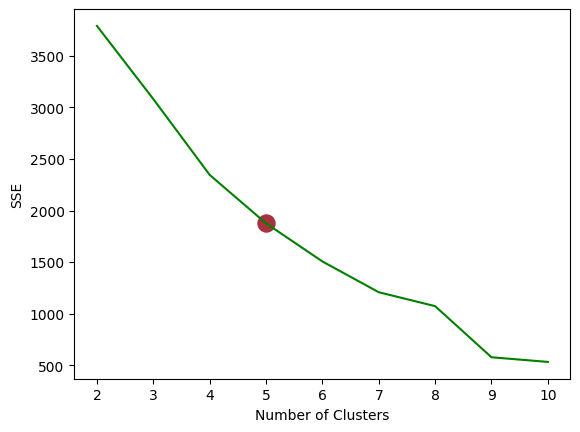

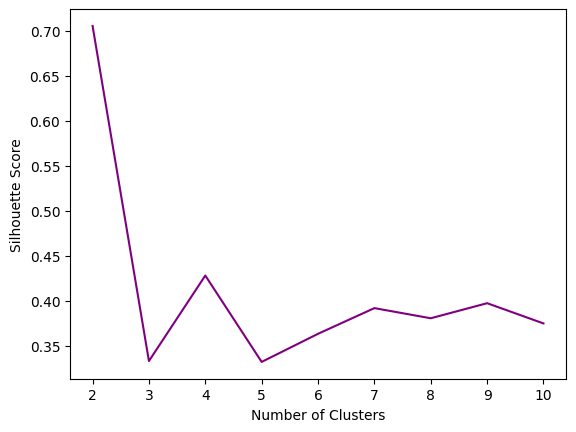

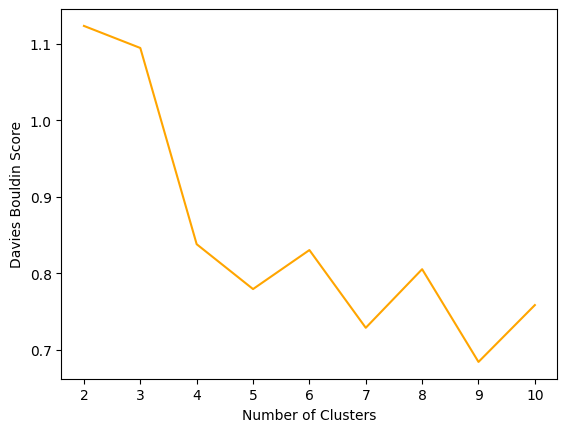

In [29]:
model = PCA(n_components = 3,random_state = 0)
model_data = model.fit_transform(scaled_data)
compare_dimensionality_reduction_kmeans(pd.DataFrame(model_data))

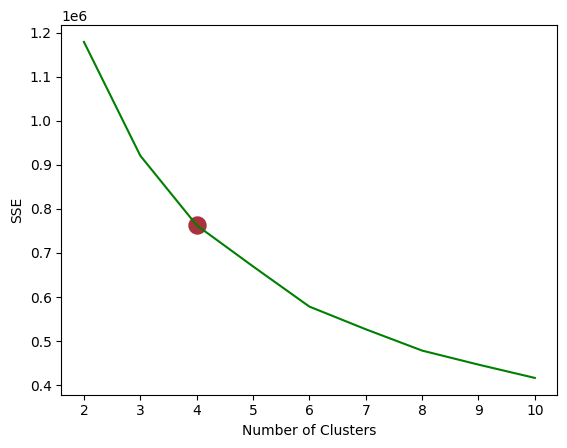

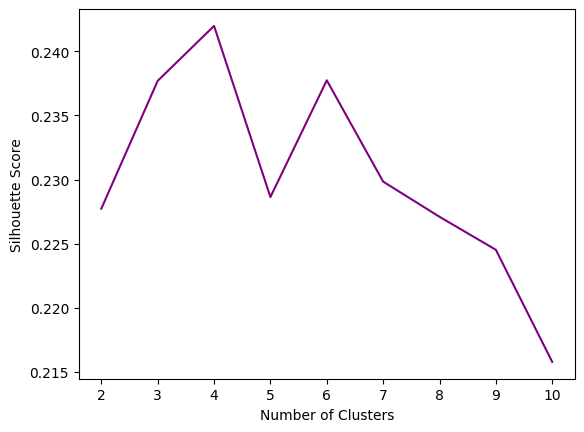

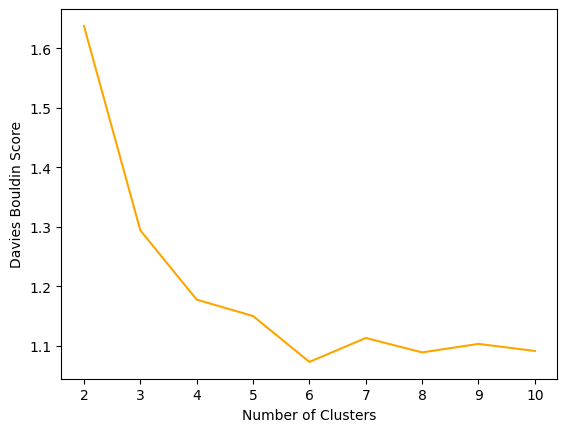

In [30]:
model = TSNE(n_components = 3,random_state = 0)
model_data = model.fit_transform(scaled_data)
compare_dimensionality_reduction_kmeans(pd.DataFrame(model_data))

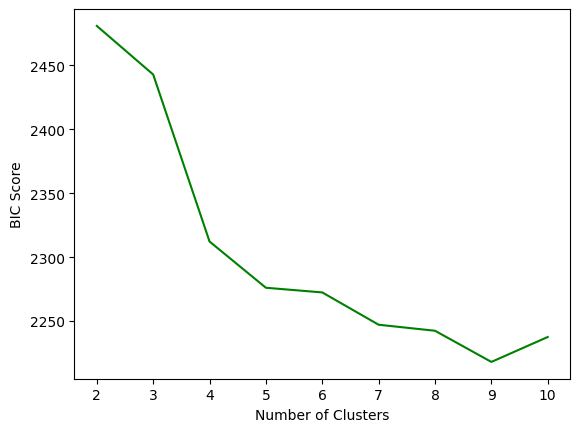

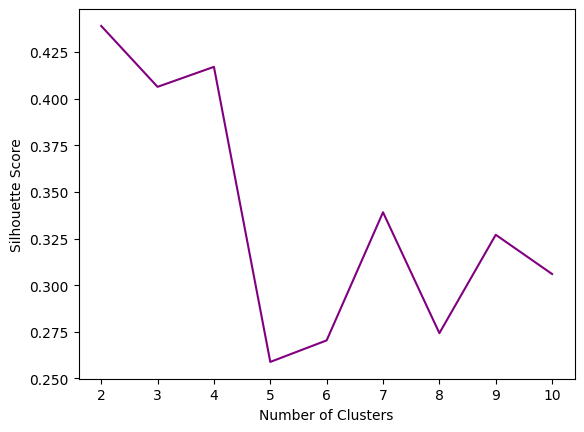

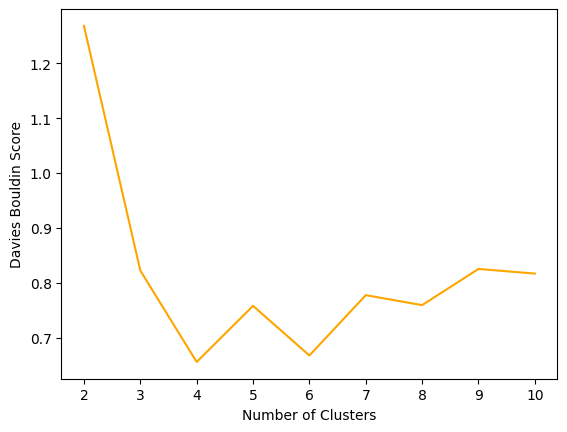

In [31]:
model = PCA(n_components = 3,random_state = 0)
model_data = model.fit_transform(scaled_data)
compare_dimensionality_reduction_gaussian(pd.DataFrame(model_data))

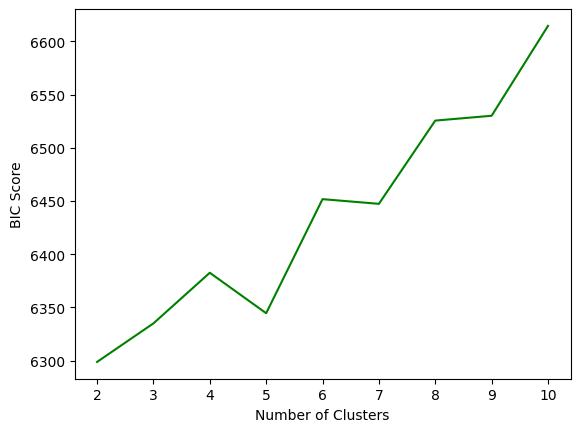

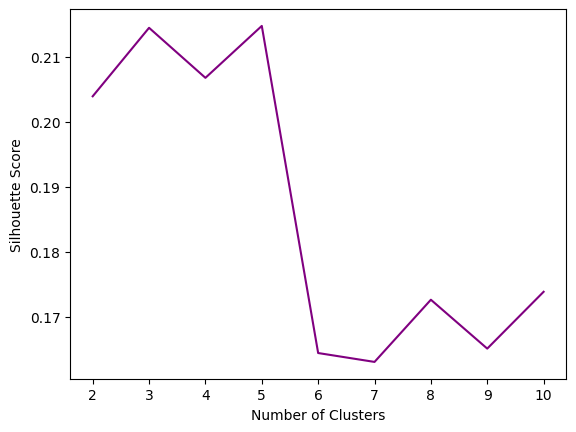

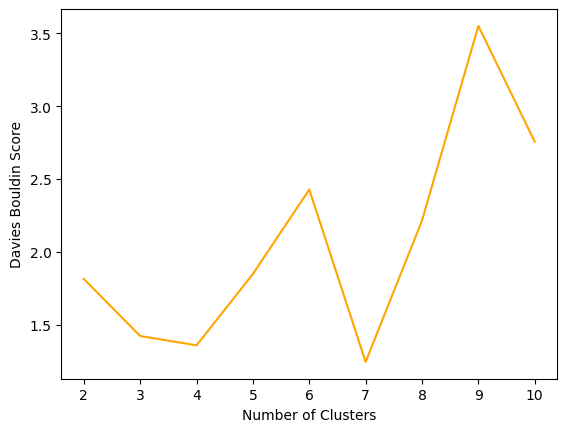

In [32]:
model = TSNE(n_components = 3,random_state = 0)
model_data = model.fit_transform(scaled_data)
compare_dimensionality_reduction_gaussian(pd.DataFrame(model_data))

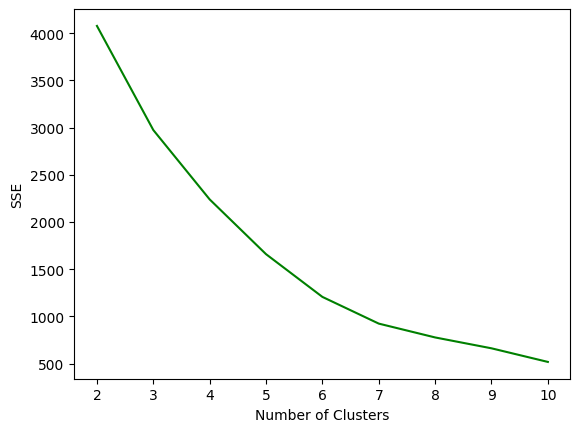

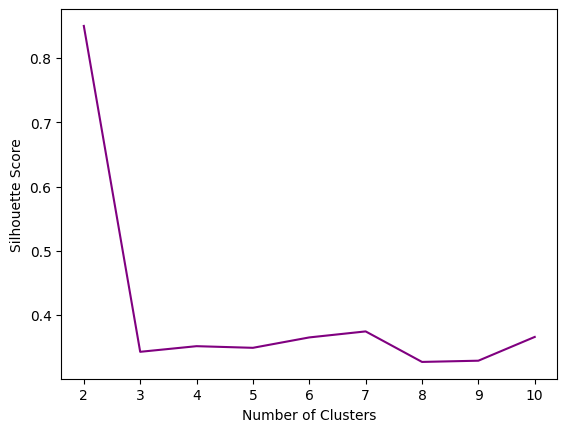

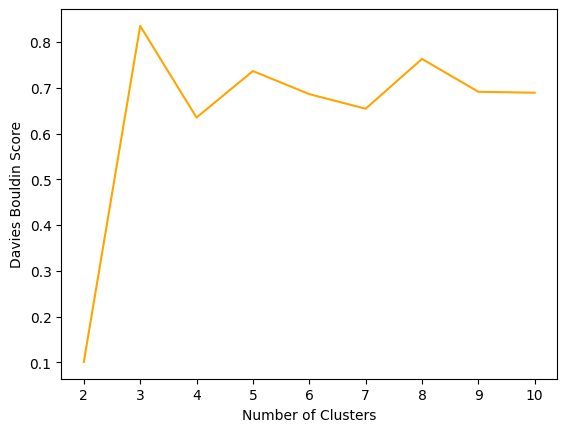

In [33]:
model = PCA(n_components = 3,random_state = 0)
model_data = model.fit_transform(scaled_data)
compare_dimensionality_reduction_linkage(pd.DataFrame(model_data))

In [34]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
             torch.nn.Linear(146, 73),
             torch.nn.ReLU(inplace=True),
             torch.nn.Linear(73, 36),
             torch.nn.ReLU(inplace=True),
             torch.nn.Linear(36, 18),
             torch.nn.ReLU(inplace=True),
             torch.nn.Linear(18, 9),
             torch.nn.ReLU(inplace=True),
             torch.nn.Linear(9, 3)

             )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 9),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(36, 73),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(73, 146),
            torch.nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [35]:
model = AE()

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [36]:
X_tensor = torch.tensor(scaled_data.values, dtype=torch.float32)

In [37]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

epochs = 100
outputs = []
losses = []
first = True

for epoch in range(epochs):
    total_loss = 0
    empty_tensor = torch.empty((0, 3))

    for feature in dataloader:
        feature = feature[0]
        feature = feature.view(feature.size(0), -1)

        latent, reconstructed = model(feature)

        loss = loss_function(reconstructed, feature)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()


        empty_tensor = torch.cat((empty_tensor, latent), dim=0)


    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    if epoch == epochs - 1:
        outputs.append((epoch, empty_tensor))

    print('After epoch %d: Loss=%.4f' % (epoch, avg_loss))

After epoch 0: Loss=1.0070
After epoch 1: Loss=1.0059
After epoch 2: Loss=1.0060
After epoch 3: Loss=1.0111
After epoch 4: Loss=1.0097
After epoch 5: Loss=1.0059
After epoch 6: Loss=1.0065
After epoch 7: Loss=1.0071
After epoch 8: Loss=1.0075
After epoch 9: Loss=1.0031
After epoch 10: Loss=1.0078
After epoch 11: Loss=1.0080
After epoch 12: Loss=1.0045
After epoch 13: Loss=1.0039
After epoch 14: Loss=1.0079
After epoch 15: Loss=1.0052
After epoch 16: Loss=1.0135
After epoch 17: Loss=1.0056
After epoch 18: Loss=1.0070
After epoch 19: Loss=0.9996
After epoch 20: Loss=1.0006
After epoch 21: Loss=1.0096
After epoch 22: Loss=1.0090
After epoch 23: Loss=0.9987
After epoch 24: Loss=1.0074
After epoch 25: Loss=1.0028
After epoch 26: Loss=1.0038
After epoch 27: Loss=1.0052
After epoch 28: Loss=1.0014
After epoch 29: Loss=0.9991
After epoch 30: Loss=1.0030
After epoch 31: Loss=1.0002
After epoch 32: Loss=1.0006
After epoch 33: Loss=1.0049
After epoch 34: Loss=1.0067
After epoch 35: Loss=1.0116
Af

In [38]:
pd.DataFrame(outputs[0][1].detach().numpy())

,0,1,2
0,0.376810,-0.353217,-0.212703
1,0.319775,-0.320637,-0.052330
2,0.418460,-0.410111,-0.244050
3,0.400667,-0.422573,-0.187896
4,0.469773,-0.447032,-0.336531
...,...,...,...
188,0.306819,-0.382373,-0.222715
189,0.127836,-0.358728,0.293098
190,0.361189,-0.336926,-0.190970
191,0.404169,-0.363528,-0.233313


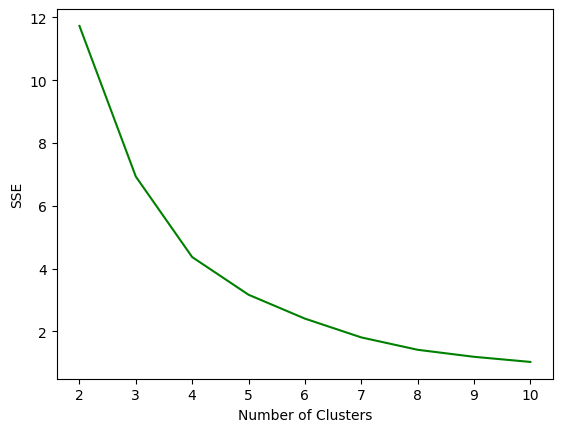

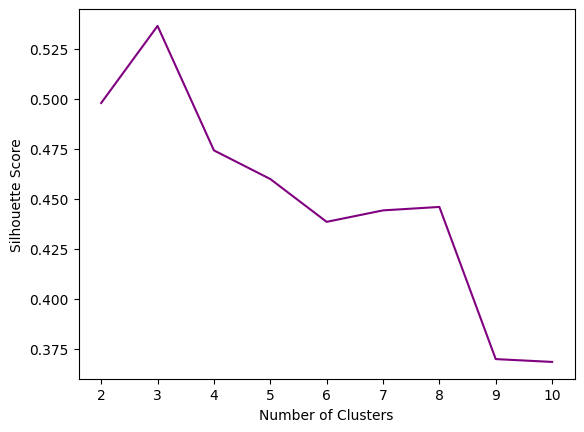

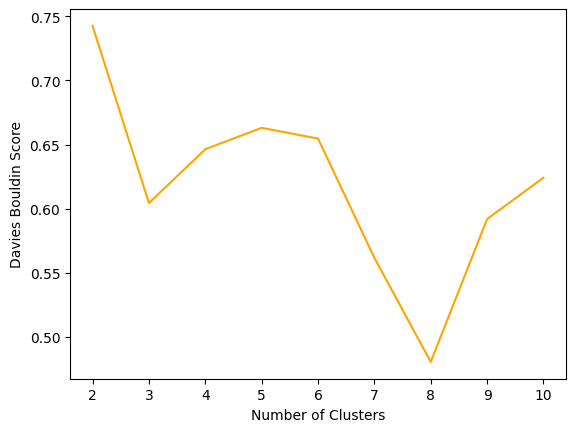

In [39]:
model = PCA(n_components = 3,random_state = 0)
model_data = model.fit_transform(scaled_data)
compare_dimensionality_reduction_linkage(pd.DataFrame(pd.DataFrame(outputs[0][1].detach().numpy())))

In [40]:
#capture feature importance
#make pca cluster plot
#False positive and negative in problem 7

In [41]:
import matplotlib.patches as mpatches

<font size = "4">PCA 2 dimensions, kmeans</font>

In [42]:
kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300, 'random_state':100}
kmeans = KMeans(n_clusters = 5, **kmeans_kwargs)
model = PCA(n_components = 2,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = kmeans.fit_predict(model_data)
model_data = model_data.rename({0:"PC1",1:"PC2"}, axis = 1)
pca_2_chart = alt.Chart(model_data).mark_circle(size = 60).encode(
    x = alt.X("PC1", title = "PC1"),
    y = alt.Y("PC2", title = "PC2"),
    color = alt.Color("Cluster:N")
).properties(title = alt.TitleParams(text = "PC1 vs PC2 by Cluster"))
pca_2_chart

alt.Chart(...)

<font size = "4">TSNE 2 dimensions, kmeans</font>

In [43]:
kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300, 'random_state':100}
kmeans = KMeans(n_clusters = 5, **kmeans_kwargs)
model = TSNE(n_components = 2,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = kmeans.fit_predict(model_data)
model_data = model_data.rename({0:"TSNE1",1:"TSNE2"}, axis = 1)
tsne_2_chart = alt.Chart(model_data).mark_circle(size = 60).encode(
    x = alt.X("TSNE1", title = "TSNE1"),
    y = alt.Y("TSNE2", title = "TSNE2"),
    color = alt.Color("Cluster:N")
).properties(title = alt.TitleParams(text = "TSNE1 vs TSNE2 by Cluster"))
tsne_2_chart

alt.Chart(...)

<font size = "4">PCA 3 dimensions, kmeans</font>

In [44]:
from mpl_toolkits.mplot3d import Axes3D

In [45]:
#What is the political instability commonality in all clusters
#Include boxplot of political instability values

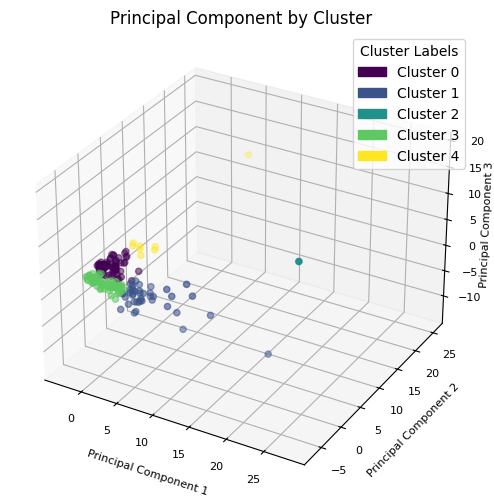

In [46]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (6,6))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')


kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300, 'random_state':100}
kmeans = KMeans(n_clusters = 5, **kmeans_kwargs)
model = PCA(n_components = 3,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = kmeans.fit_predict(model_data)
# defining all 3 axis
z = model_data[2]
x = model_data[0]
y = model_data[1]
 
# plotting
cmap = plt.get_cmap("viridis")
ax.scatter3D(x, y, z, c = model_data["Cluster"])
ax.set_title('Principal Component by Cluster')



# Create legend manually
unique_clusters = np.unique(model_data["Cluster"])
legend_patches = [mpatches.Patch(color=cmap(i / max(unique_clusters)), label=f"Cluster {i}") for i in unique_clusters]

# Add legend
ax.legend(handles=legend_patches, title="Cluster Labels")

# Labels and title
ax.set_xlabel("Principal Component 1", fontsize = 8,labelpad = 5)
ax.set_ylabel("Principal Component 2",fontsize = 8)
ax.set_zlabel("Principal Component 3",fontsize = 8,labelpad = -3)
ax.tick_params(axis='z', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

plt.show()

<font size = "4">TSNE 3 dimensions, kmeans</font>

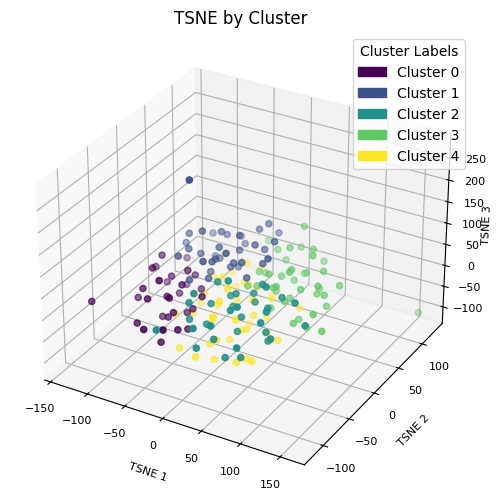

In [47]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (6,6))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')


kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300, 'random_state':100}
kmeans = KMeans(n_clusters = 5, **kmeans_kwargs)
model = TSNE(n_components = 3,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = kmeans.fit_predict(model_data)
# defining all 3 axis
z = model_data[2]
x = model_data[0]
y = model_data[1]
 
# plotting
cmap = plt.get_cmap("viridis")
ax.scatter3D(x, y, z, c = model_data["Cluster"])
ax.set_title('TSNE by Cluster')



# Create legend manually
unique_clusters = np.unique(model_data["Cluster"])
legend_patches = [mpatches.Patch(color=cmap(i / max(unique_clusters)), label=f"Cluster {i}") for i in unique_clusters]

# Add legend
ax.legend(handles=legend_patches, title="Cluster Labels")

# Labels and title
ax.set_xlabel("TSNE 1", fontsize = 8,labelpad = 5)
ax.set_ylabel("TSNE 2",fontsize = 8)
ax.set_zlabel("TSNE 3",fontsize = 8,labelpad = -3)
ax.tick_params(axis='z', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

plt.show()

<font size = "4">AE 2 dimensions, kmeans</font>

In [48]:
ae_data = pd.read_csv("AE_data.csv")

In [49]:
kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300, 'random_state':100}
kmeans = KMeans(n_clusters = 5, **kmeans_kwargs)
ae_data["Cluster"] = kmeans.fit_predict(ae_data)
ae_data = ae_data.rename({"0":"Feature 1","1":"Feature 2"}, axis = 1)
ae_chart = alt.Chart(ae_data).mark_circle(size = 60).encode(
    x = alt.X("Feature 1", title = "Feature 1"),
    y = alt.Y("Feature 2", title = "Feature 2"),
    color = alt.Color("Cluster:N")
).properties(title = alt.TitleParams(text = "Feature 1 vs Feature 2 by Cluster"))
ae_chart

alt.Chart(...)

<font size = "4">PCA 2 dimensions, Gaussian Mixture</font>

In [50]:
gmm = GaussianMixture(n_components=7, random_state = 42)
model = PCA(n_components = 2,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = gmm.fit_predict(model_data)
model_data = model_data.rename({0:"PC1",1:"PC2"}, axis = 1)
pca_2_chart = alt.Chart(model_data).mark_circle(size = 60).encode(
    x = alt.X("PC1", title = "PC1"),
    y = alt.Y("PC2", title = "PC2"),
    color = alt.Color("Cluster:N")
).properties(title = alt.TitleParams(text = "PC1 vs PC2 by Cluster"))
pca_2_chart

alt.Chart(...)

<font size = "4">PCA 3 dimensions, Gaussian Mixture</font>

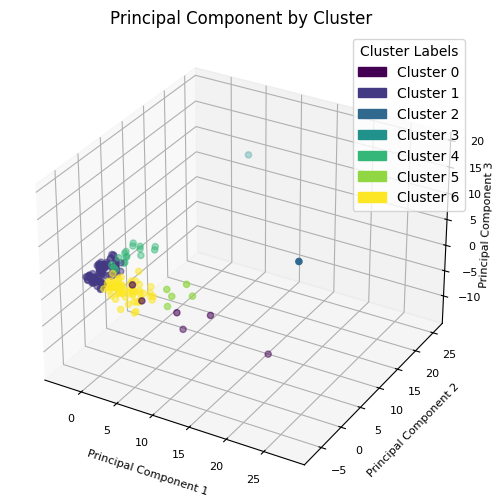

In [51]:
fig = plt.figure(figsize = (6,6))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

gmm = GaussianMixture(n_components=7, random_state = 42)
model = PCA(n_components = 3,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = gmm.fit_predict(model_data)
# defining all 3 axis
z = model_data[2]
x = model_data[0]
y = model_data[1]
 
# plotting
cmap = plt.get_cmap("viridis")
ax.scatter3D(x, y, z, c = model_data["Cluster"])
ax.set_title('Principal Component by Cluster')



# Create legend manually
unique_clusters = np.unique(model_data["Cluster"])
legend_patches = [mpatches.Patch(color=cmap(i / max(unique_clusters)), label=f"Cluster {i}") for i in unique_clusters]

# Add legend
ax.legend(handles=legend_patches, title="Cluster Labels")

# Labels and title
ax.set_xlabel("Principal Component 1", fontsize = 8,labelpad = 5)
ax.set_ylabel("Principal Component 2",fontsize = 8)
ax.set_zlabel("Principal Component 3",fontsize = 8,labelpad = -3)
ax.tick_params(axis='z', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

plt.show()

<font size = "4">TSNE 2 dimensions, Gaussian Mixture</font>

In [52]:
gmm = GaussianMixture(n_components=7, random_state = 42)
model = TSNE(n_components = 2,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = gmm.fit_predict(model_data)
model_data = model_data.rename({0:"TSNE1",1:"TSNE2"}, axis = 1)
pca_2_chart = alt.Chart(model_data).mark_circle(size = 60).encode(
    x = alt.X("TSNE1", title = "TSNE1"),
    y = alt.Y("TSNE2", title = "TSNE2"),
    color = alt.Color("Cluster:N")
).properties(title = alt.TitleParams(text = "TSNE1 vs TSNE2 by Cluster"))
pca_2_chart

alt.Chart(...)

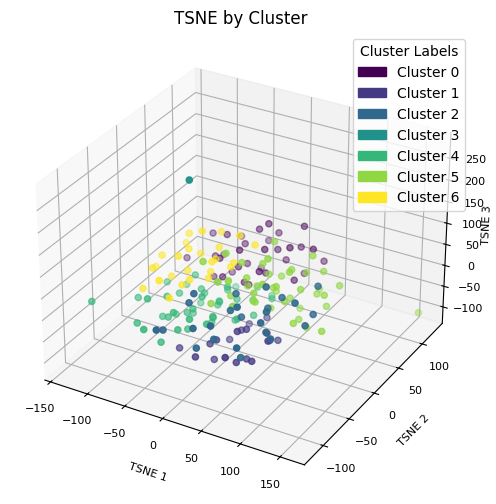

In [53]:
fig = plt.figure(figsize = (6,6))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

gmm = GaussianMixture(n_components=7, random_state = 42)
model = TSNE(n_components = 3,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = gmm.fit_predict(model_data)
# defining all 3 axis
z = model_data[2]
x = model_data[0]
y = model_data[1]
 
# plotting
cmap = plt.get_cmap("viridis")
ax.scatter3D(x, y, z, c = model_data["Cluster"])
ax.set_title('TSNE by Cluster')



# Create legend manually
unique_clusters = np.unique(model_data["Cluster"])
legend_patches = [mpatches.Patch(color=cmap(i / max(unique_clusters)), label=f"Cluster {i}") for i in unique_clusters]

# Add legend
ax.legend(handles=legend_patches, title="Cluster Labels")

# Labels and title
ax.set_xlabel("TSNE 1", fontsize = 8,labelpad = 5)
ax.set_ylabel("TSNE 2",fontsize = 8)
ax.set_zlabel("TSNE 3",fontsize = 8,labelpad = -3)
ax.tick_params(axis='z', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

plt.show()

In [54]:
gmm = GaussianMixture(n_components=7, random_state = 42)
ae_data["Cluster"] = gmm.fit_predict(ae_data)
ae_data = ae_data.rename({"0":"Feature 1","1":"Feature 2"}, axis = 1)
ae_chart = alt.Chart(ae_data).mark_circle(size = 60).encode(
    x = alt.X("Feature 1", title = "Feature 1"),
    y = alt.Y("Feature 2", title = "Feature 2"),
    color = alt.Color("Cluster:N")
).properties(title = alt.TitleParams(text = "Feature 1 vs Feature 2 by Cluster"))
ae_chart

alt.Chart(...)

<font size = "4">PCA 2 dimensions, Hierarchal Clustering</font>

In [55]:
hierarchical = linkage(model_data, method='ward')
model = PCA(n_components = 2,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = fcluster(hierarchical, 7, criterion='maxclust')
model_data = model_data.rename({0:"PC1",1:"PC2"}, axis = 1)
pca_2_chart = alt.Chart(model_data).mark_circle(size = 60).encode(
    x = alt.X("PC1", title = "PC1"),
    y = alt.Y("PC2", title = "PC2"),
    color = alt.Color("Cluster:N")
).properties(title = alt.TitleParams(text = "PC1 vs PC2 by Cluster"))
pca_2_chart 

alt.Chart(...)

<font size = "4">PCA 3 dimensions, Hierarchal Clustering</font>

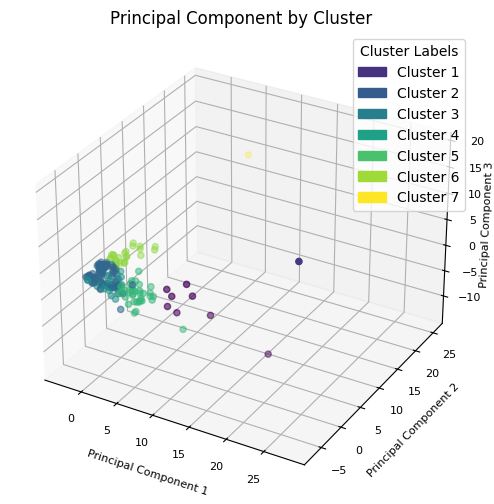

In [56]:
fig = plt.figure(figsize = (6,6))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

hierarchical = linkage(model_data, method='ward')

model = PCA(n_components = 3,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = fcluster(hierarchical, 7, criterion='maxclust')
# defining all 3 axis
z = model_data[2]
x = model_data[0]
y = model_data[1]
 
# plotting
cmap = plt.get_cmap("viridis")
ax.scatter3D(x, y, z, c = model_data["Cluster"])
ax.set_title('Principal Component by Cluster')



# Create legend manually
unique_clusters = np.unique(model_data["Cluster"])
legend_patches = [mpatches.Patch(color=cmap(i / max(unique_clusters)), label=f"Cluster {i}") for i in unique_clusters]

# Add legend
ax.legend(handles=legend_patches, title="Cluster Labels")

# Labels and title
ax.set_xlabel("Principal Component 1", fontsize = 8,labelpad = 5)
ax.set_ylabel("Principal Component 2",fontsize = 8)
ax.set_zlabel("Principal Component 3",fontsize = 8,labelpad = -3)
ax.tick_params(axis='z', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

plt.show()

<font size = "4">TSNE 2 dimensions, Hierarchal Clustering</font>

In [57]:
hierarchical = linkage(model_data, method='ward')
model = TSNE(n_components = 2,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = fcluster(hierarchical, 7, criterion='maxclust')
model_data = model_data.rename({0:"TSNE1",1:"TSNE2"}, axis = 1)
tsne_2_chart = alt.Chart(model_data).mark_circle(size = 60).encode(
    x = alt.X("TSNE1", title = "TSNE1"),
    y = alt.Y("TSNE2", title = "TSNE2"),
    color = alt.Color("Cluster:N")
).properties(title = alt.TitleParams(text = "TSNE1 vs TSNE2 by Cluster"))
tsne_2_chart 

alt.Chart(...)

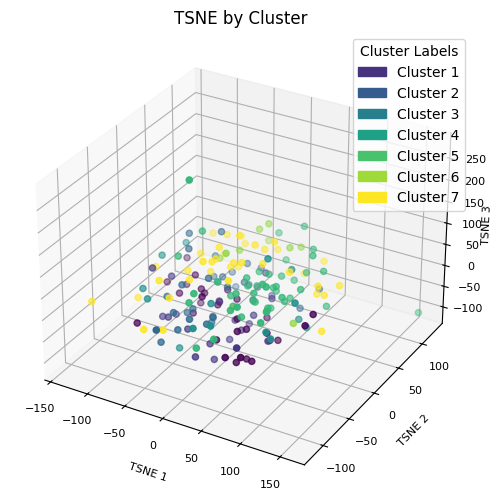

In [58]:
fig = plt.figure(figsize = (6,6))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

hierarchical = linkage(model_data, method='ward')

model = TSNE(n_components = 3,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = fcluster(hierarchical, 7, criterion='maxclust')
# defining all 3 axis
z = model_data[2]
x = model_data[0]
y = model_data[1]
 
# plotting
cmap = plt.get_cmap("viridis")
ax.scatter3D(x, y, z, c = model_data["Cluster"])
ax.set_title('TSNE by Cluster')



# Create legend manually
unique_clusters = np.unique(model_data["Cluster"])
legend_patches = [mpatches.Patch(color=cmap(i / max(unique_clusters)), label=f"Cluster {i}") for i in unique_clusters]

# Add legend
ax.legend(handles=legend_patches, title="Cluster Labels")

# Labels and title
ax.set_xlabel("TSNE 1", fontsize = 8,labelpad = 5)
ax.set_ylabel("TSNE 2",fontsize = 8)
ax.set_zlabel("TSNE 3",fontsize = 8,labelpad = -3)
ax.tick_params(axis='z', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

plt.show()

<font size = "4">AE 2 dimensions, Hierarchal Clustering</font>

In [59]:
hierarchical = linkage(model_data, method='ward')
ae_data["Cluster"] = fcluster(hierarchical, 7, criterion='maxclust')
ae_data = ae_data.rename({"0":"Feature 1","1":"Feature 2"}, axis = 1)
ae_chart = alt.Chart(ae_data).mark_circle(size = 60).encode(
    x = alt.X("Feature 1", title = "Feature 1"),
    y = alt.Y("Feature 2", title = "Feature 2"),
    color = alt.Color("Cluster:N")
).properties(title = alt.TitleParams(text = "Feature 1 vs Feature 2 by Cluster"))
ae_chart

alt.Chart(...)

Step 6: PCA (3D) + K-Means (k=5) is the best scheme

In [60]:
kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300, 'random_state':100}
kmeans = KMeans(n_clusters = 5, **kmeans_kwargs)
model = PCA(n_components = 3,random_state = 0)
model_data = pd.DataFrame(model.fit_transform(scaled_data))
model_data["Cluster"] = kmeans.fit_predict(model_data)
# defining all 3 axis
z = model_data[2]
x = model_data[0]
y = model_data[1]

In [62]:
df2

,Polarization,pa_count,Immigration,Life Expectancy,riot_section,Height,EVI,nc_count,ky_count,HSUS,...,ga_count,Population,il_count,mo_count,fatalities,type_subtype_sum,Wage GDP Ratio,ms_count,la_count,Political Instability
0,-1.642954,-0.508810,-2.022672,0.475214,-0.207453,-0.229265,-0.941860,-0.306855,-0.369244,-1.442408,...,-0.331021,-1.205319,-0.473481,-0.373337,-0.346788,-0.652637,1.345003,-0.426375,-0.365791,-1.088771
1,-1.642954,2.608659,-2.022672,0.538631,-0.207453,-0.244490,-0.941860,-0.306855,-0.369244,-1.477072,...,-0.331021,-1.202907,-0.473481,-0.373337,-0.306140,-0.526678,1.345003,-0.426375,-0.365791,1.143161
2,-1.642954,-0.508810,-2.022672,0.547155,-0.207453,-0.274940,-0.941860,-0.306855,-0.369244,-1.464283,...,-0.331021,-1.198855,-0.473481,-0.373337,-0.250248,-0.274760,1.345003,-0.426375,-0.365791,2.099389
3,-1.642954,-0.508810,-2.022672,0.560401,-0.207453,-0.290165,-0.941860,-0.306855,-0.369244,-1.521907,...,-0.331021,-1.197474,-0.473481,-0.373337,-0.336626,-0.652637,1.348500,-0.426375,-0.365791,2.163410
4,-0.644674,-0.508810,-2.005298,0.545257,-0.207453,-0.302853,-0.939850,-0.306855,-0.369244,-1.539756,...,-0.331021,-1.193278,-0.473481,-0.373337,-0.346788,-0.778596,1.611980,-0.426375,-0.365791,1.777819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,1.949369,-0.508810,0.557924,1.079789,-0.207453,0.987801,0.708684,-0.306855,-0.369244,1.023952,...,-0.331021,2.076413,-0.473481,1.264256,-0.235005,-0.778596,-1.696343,-0.426375,-0.365791,-0.840085
189,1.999512,-0.508810,0.557924,1.079789,-0.207453,0.987801,0.731203,-0.306855,-0.369244,1.023952,...,-0.331021,2.105305,-0.473481,-0.373337,-0.209600,-0.526678,-1.723780,-0.426375,0.436456,-1.017228
190,2.048350,0.270557,0.557924,1.079789,-0.207453,0.987801,0.755938,-0.306855,-0.369244,1.023952,...,-0.331021,2.133254,0.498666,2.901850,-0.036845,-0.400719,-1.707418,-0.426375,0.436456,-0.617034
191,2.095826,2.608659,0.557924,1.079789,-0.207453,0.987801,0.785012,0.953211,1.929597,1.023952,...,0.219729,2.160259,0.498666,-0.373337,0.374530,1.236747,-1.736365,-0.426375,-0.365791,-0.041424


In [ ]:
model_data

,0,1,2,Cluster
0,-2.420690,-2.017545,1.286465,3
1,-1.647425,-1.713881,1.078242,3
2,-2.549893,-2.589389,1.309991,3
3,-2.686514,-2.296241,1.067263,3
4,-2.687336,-2.335034,0.964816,3
...,...,...,...,...
188,-1.986276,4.661264,0.891068,0
189,-1.490853,2.946014,0.396314,0
190,-0.426915,5.732419,2.155338,4
191,3.787448,25.329847,9.069391,4


In [65]:
import seaborn as sns
df_clustered = pd.concat([df2, model_data["Cluster"]], axis=1)

if "Political Instability" not in df_clustered.columns:
    raise ValueError("Ensure the original dataset includes 'Political Instability'.")


df_clustered.to_csv("clustered_data.csv", index=False)
print(df_clustered.head()) 

   Polarization  pa_count  Immigration  Life Expectancy  riot_section  \
0     -1.642954 -0.508810    -2.022672         0.475214     -0.207453   
1     -1.642954  2.608659    -2.022672         0.538631     -0.207453   
2     -1.642954 -0.508810    -2.022672         0.547155     -0.207453   
3     -1.642954 -0.508810    -2.022672         0.560401     -0.207453   
4     -0.644674 -0.508810    -2.005298         0.545257     -0.207453   

     Height      EVI  nc_count  ky_count      HSUS  ...  Population  il_count  \
0 -0.229265 -0.94186 -0.306855 -0.369244 -1.442408  ...   -1.205319 -0.473481   
1 -0.244490 -0.94186 -0.306855 -0.369244 -1.477072  ...   -1.202907 -0.473481   
2 -0.274940 -0.94186 -0.306855 -0.369244 -1.464283  ...   -1.198855 -0.473481   
3 -0.290165 -0.94186 -0.306855 -0.369244 -1.521907  ...   -1.197474 -0.473481   
4 -0.302853 -0.93985 -0.306855 -0.369244 -1.539756  ...   -1.193278 -0.473481   

   mo_count  fatalities  type_subtype_sum  Wage GDP Ratio  ms_count  la_co

/var/folders/yy/s7twnlfx5yv1vvp28hns9vwh0000gn/T/ipykernel_14661/3141647235.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Political Instability", data=df_final, palette="viridis")


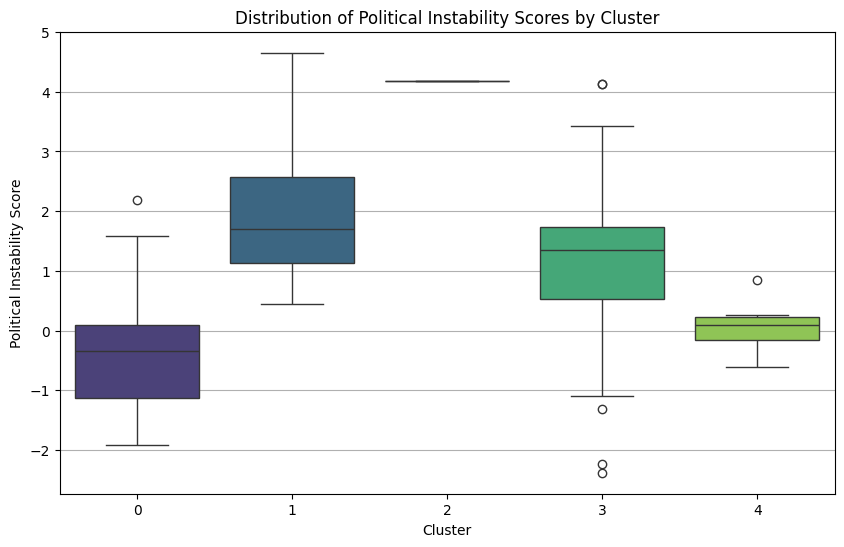

         count      mean       std       min       25%       50%       75%  \
Cluster                                                                      
0         70.0 -0.413439  0.920052 -1.909143 -1.126478 -0.351319  0.096757   
1         41.0  1.988656  1.181041  0.444140  1.126249  1.696652  2.574643   
2          1.0  4.180910       NaN  4.180910  4.180910  4.180910  4.180910   
3         73.0  1.119088  1.232243 -2.381809  0.530548  1.346543  1.737719   
4          8.0  0.040487  0.462890 -0.617034 -0.159559  0.092774  0.218959   

              max  
Cluster            
0        2.180309  
1        4.653176  
2        4.180910  
3        4.134947  
4        0.848888  


In [ ]:
df_final = pd.read_csv("clustered_data.csv")  

# Boxplot of instability scores by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x="Cluster", y="Political Instability", data=df_final, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Political Instability Score")
plt.title("Distribution of Political Instability Scores by Cluster")
plt.grid(axis="y")
plt.show()

# Summary statistics for each cluster
summary_stats = df_final.groupby("Cluster")["Political Instability"].describe()
print(summary_stats)


In [72]:
df_year = pd.concat([df_final, df["Year"]], axis=1)
df_year

,Polarization,pa_count,Immigration,Life Expectancy,riot_section,Height,EVI,nc_count,ky_count,HSUS,...,il_count,mo_count,fatalities,type_subtype_sum,Wage GDP Ratio,ms_count,la_count,Political Instability,Cluster,Year
0,-1.642954,-0.508810,-2.022672,0.475214,-0.207453,-0.229265,-0.941860,-0.306855,-0.369244,-1.442408,...,-0.473481,-0.373337,-0.346788,-0.652637,1.345003,-0.426375,-0.365791,-1.088771,3,1782
1,-1.642954,2.608659,-2.022672,0.538631,-0.207453,-0.244490,-0.941860,-0.306855,-0.369244,-1.477072,...,-0.473481,-0.373337,-0.306140,-0.526678,1.345003,-0.426375,-0.365791,1.143161,3,1784
2,-1.642954,-0.508810,-2.022672,0.547155,-0.207453,-0.274940,-0.941860,-0.306855,-0.369244,-1.464283,...,-0.473481,-0.373337,-0.250248,-0.274760,1.345003,-0.426375,-0.365791,2.099389,3,1787
3,-1.642954,-0.508810,-2.022672,0.560401,-0.207453,-0.290165,-0.941860,-0.306855,-0.369244,-1.521907,...,-0.473481,-0.373337,-0.336626,-0.652637,1.348500,-0.426375,-0.365791,2.163410,3,1788
4,-0.644674,-0.508810,-2.005298,0.545257,-0.207453,-0.302853,-0.939850,-0.306855,-0.369244,-1.539756,...,-0.473481,-0.373337,-0.346788,-0.778596,1.611980,-0.426375,-0.365791,1.777819,3,1791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,1.949369,-0.508810,0.557924,1.079789,-0.207453,0.987801,0.708684,-0.306855,-0.369244,1.023952,...,-0.473481,1.264256,-0.235005,-0.778596,-1.696343,-0.426375,-0.365791,-0.840085,0,2006
189,1.999512,-0.508810,0.557924,1.079789,-0.207453,0.987801,0.731203,-0.306855,-0.369244,1.023952,...,-0.473481,-0.373337,-0.209600,-0.526678,-1.723780,-0.426375,0.436456,-1.017228,0,2007
190,2.048350,0.270557,0.557924,1.079789,-0.207453,0.987801,0.755938,-0.306855,-0.369244,1.023952,...,0.498666,2.901850,-0.036845,-0.400719,-1.707418,-0.426375,0.436456,-0.617034,4,2008
191,2.095826,2.608659,0.557924,1.079789,-0.207453,0.987801,0.785012,0.953211,1.929597,1.023952,...,0.498666,-0.373337,0.374530,1.236747,-1.736365,-0.426375,-0.365791,-0.041424,4,2009


In [86]:
scatter_chart = alt.Chart(df_year).mark_circle(size=60, opacity=0.7).encode(
    x=alt.X("Year:N", title="Year", axis=alt.Axis(values=list(range(int(df_year["Year"].min()), int(df_year["Year"].max()) + 1, 4)))),
    y=alt.Y("Political Instability:Q", title="Political Instability Score"),
    color=alt.Color("Cluster:N", title="Cluster", scale=alt.Scale(scheme="viridis"))
).properties(
    title="Year vs. Political Instability (Colored by Cluster)",
    width=1000,
    height=500
)
scatter_chart


alt.Chart(...)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


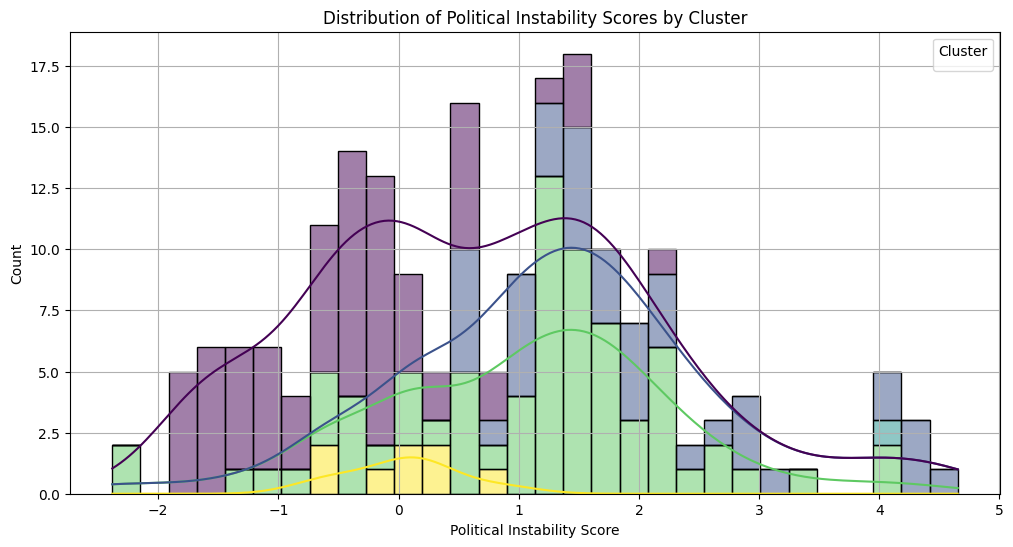

In [75]:
plt.figure(figsize=(12, 6))
sns.histplot(df_year, x="Political Instability", hue="Cluster", bins=30, palette="viridis", multiple="stack", kde=True)
plt.xlabel("Political Instability Score")
plt.ylabel("Count")
plt.title("Distribution of Political Instability Scores by Cluster")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

/var/folders/yy/s7twnlfx5yv1vvp28hns9vwh0000gn/T/ipykernel_14661/4064097005.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x="Cluster", y="Political Instability", data=df_year, palette="viridis", inner="quartile")


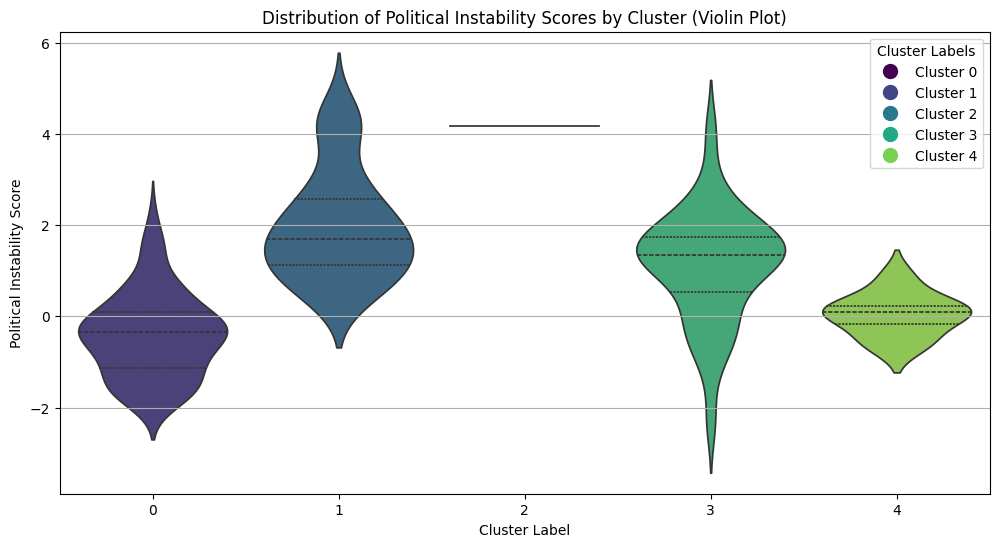

In [91]:
# Violin plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Cluster", y="Political Instability", data=df_year, palette="viridis", inner="quartile")
plt.xlabel("Cluster Label")
plt.ylabel("Political Instability Score")
plt.title("Distribution of Political Instability Scores by Cluster (Violin Plot)")
plt.grid(axis="y")

handles = [plt.Line2D([0], [0], color=sns.color_palette("viridis", as_cmap=True)(i / df_year["Cluster"].nunique()), marker='o', linestyle='', markersize=10) for i in range(df_year["Cluster"].nunique())]
labels = [f"Cluster {i}" for i in range(df_year["Cluster"].nunique())]

plt.legend(handles, labels, title="Cluster Labels", loc="upper right", frameon=True)
plt.show()
